In [1]:
from __future__ import division  # float division
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import numpy as np

from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn import grid_search
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.cross_validation import StratifiedKFold, train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB

# 1. Overview of the data set

In [26]:
data = pd.read_csv("SampleData.csv")

# Create a new column to indicate whether there's a new purchase between May 2015 and Dec 2015.
# 1 means yes, 0 means no. This is our target column.
def target(row):
    # Check if the purchase dates up to May 2015 and Dec 2015 are the same
    # If not, it means there's a new purchase
    if row["Home Purchase Date (YYYY/MM)_hist"]!=row["Home Purchase Date (YYYY/MM)_curr"]:
        return 1
    else:
        return 0
    
data.loc[:,"New_Purchase"]=data.apply(lambda row: target(row), axis=1)

# Number of records that show a new home purchase between May 2015 and Dec 2015
nmoved = data[data.New_Purchase==1].shape[0]
ntotal = data.shape[0]
# Percentage of household that moved between May 2015 and Dec 2015
p_moved = nmoved/ntotal
baseline = 1 - p_moved

print "%f of household moved" % p_moved
print "The baseline accuracy for our classifier is %f" % baseline

0.112994 of household moved
The baseline accuracy for our classifier is 0.887006


The two classes are unbalanced in this data set, with only 11.3% in the "moved" class. Therefore, our model performance should be compared with the baseline of blindingly predicting 'will move' for every household, which gives an accuracy of about 88.7%.

# 2. Data transformation: dealing with missing data

Missing data can be delt with in many different ways. In order to maximize the utilization of data, I will try not to remove records with missing values in some of the features. Some of the missing data are quite easy to deal with. For example, to deal with missing data in categorical features, we can simply treat it as another "category" for our model to learn, because if we don't know the value for that feature, these records are naturally in a separate category. Some other features such as "Newlywed" and "Expectant Parent" only denotes "Y" (yes) for positive answer, and thus we can infer that the missing data all represent "N" (no). Therefore, we can encode them into binary (0 and 1) data. Some other features like "Home Square Footage - Actual" and "Home Year Built - Actual" are numerical. In order to use these features and not reduce the sample data size, I will use the average value as an substitute for the missing values. Finally, the missing values in the "Income - Estimated Household" feature can estimated using values in the "Census Median Household Income" column. To summarize:

* Home Square Footage - Actual: 556 missing - use the average for missing values
* Home Year Built - Actual: 1806 missing - use the average for missing values
* Home Loan-to-Value - Estimated - Ranges: 6347 missing - c
* Income - Estimated Household: 2081 missing - can use "Census Median Household Income" to estimate
* Generations in Household: 1595 missing - c
* New Parent: 47223 missing - c
* Expectant Parent: 48845 missing - n
* Newlywed: 48666 missing - n
* Marital Status in the Household: 1564 missing - c

"c" in the above list indicates that we can simply treat the missing values as a separate "category".
"n" in the above list indicates that we can treate the missing values as category "no" or "N".

In [27]:
# For "Expectant Parent" and "Newlywed" columns, convert "Y" to 1 and missing value NaN to 0.
data.loc[:,'Expectant Parent'] = data['Expectant Parent'].map(lambda x: 1 if x=='Y' or x==1 else 0)
data.loc[:,'Newlywed'] = data['Newlywed'].map(lambda x: 1 if x=='Y' or x==1 else 0)

# For "New Parent", "Marital Status in the Household", "Home Loan-to-Value - Estimated - Ranges", 
# and "Generations in Household", we assign the missing data another category named "Z"
data.loc[:,'Marital Status in the Household'] = \
                         data['Marital Status in the Household'].fillna("Z")
data.loc[:,'Home Loan-to-Value - Estimated - Ranges'] = \
                         data['Home Loan-to-Value - Estimated - Ranges'].fillna('Z')
data.loc[:,'New Parent'] = data['New Parent'].fillna("Z")
data.loc[:,'Generations in Household'] = data['Generations in Household'].fillna("Z")

# For "Generations in Household", we also convert 1,2,3 to letters A, B, C 
# so that we can use pd.get_dummies() later.
data.loc[:,'Generations in Household'] = data['Generations in Household'].map(
                         lambda x: 'A' if x==1 else 'B' if x==2 else 'C' if x==3 else 'Z')

# For "Home Square Footage - Actual" and "Home Year Built - Actual", 
# use the average values to replace missing data
data.loc[:,'Home Square Footage - Actual'] = data['Home Square Footage - Actual'].fillna(
    data['Home Square Footage - Actual'].mean())
data.loc[:,'Home Year Built - Actual'] = data['Home Year Built - Actual'].fillna(
    int(data['Home Year Built - Actual'].mean()))



# For missing values in "Income - Estimated Household" column, use the corresponding 
# "Census Median Household Income" to estimate.

# First, define a function to properly assign the category of income based on 
# "Census Median Household Income" value
def categorize_income(x):
    # The numbers quoted in this column are in hundreds
    income = x*100
    if income<15000:
        return 1
    elif income<20000:
        return 2
    elif income<30000:
        return 3
    elif income<40000:
        return 4
    elif income<50000:
        return 5
    elif income<75000:
        return 6
    elif income<100000:
        return 7
    elif income<125000:
        return 8
    else:
        return 9
    
# Then fill the missing values in "Income - Estimated Household" with the income categories 
# based on "Census Median Household Income"
data.loc[data['Income - Estimated Household'].isnull(),'Income - Estimated Household'] = \
data["Census Median Household Income"].map(lambda x: categorize_income(x))
# Map 1-9 to letters A-I so that we can use pd.get_dummies() later
toletters = {1:'A',2:'B',3:'C',4:'D',5:'E',6:'F',7:'G',8:'H',9:'I'}
data.loc[:,'Income - Estimated Household'] = data['Income - Estimated Household'].map(
                                                                lambda x: toletters[x])

# 3. Predictive Model

### 3.1. Vectorize categorical features and combine them with other features using FeatureUnion

In [6]:
# This transformer does the one-hot encoding for categorical features
class DummyTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, keys):
        # initialization code with a list of feature names
        self.keys = keys

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # use get_dummies() to transform categorical data using "one-hot encoding" 
        # and output a sparse matrix
        self.dummies = pd.get_dummies(X[self.keys]).as_matrix()
        
        return self.dummies

# This transformer simply selects specified features, and output a matrix
class ColumnSelectTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, keys):
        self.keys = keys

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # output in matrix form
        self.matrix = X[self.keys].as_matrix()
        return self.matrix
    
# Combine one-hot encoded features with other features
features = FeatureUnion(transformer_list = 
                        [# Categorical features that needs to be one-hot encoded
                         ('categorical', DummyTransformer(['Home Loan-to-Value - Estimated - Ranges',
                                                          'Home Market Value - Estimated', 
                                                          'Income - Estimated Household',
                                                          'Generations in Household', 'New Parent',
                                                          'Marital Status in the Household'])),
                         # Other features
                         ('other', ColumnSelectTransformer(['Expectant Parent', 'Newlywed', 
                                                            'Home Length of Residence',
                                                            'Home Square Footage - Actual', 
                                                            'Home Year Built - Actual']))
                        ])

The 11 features I used are listed as follows:

Categorical features that need to be one-hot encoded: 
* Home Loan-to-Value - Estimated - Ranges
* Home Market Value - Estimated
* Income - Estimated Household
* Generations in Household
* New Parent
* Marital Status in the Household

Categorical features already one-hot encoded at the 'data transformation' stage:
* Expectant Parent
* Newlywed

Other features to use:
* Home Length of Residence
* Home Square Footage - Actual
* Home Year Built - Actual

### 3.2. Construct the full model using Pipeline

In this classifier, I've set 'class_weight' to be 'balanced' to take into account the skewed classes in the data set. I also set 'scoring' to 'recall' to capture more real moving households, since from the business perspective, it is more important to capture more households that are about to move instead of getting a super high precision or total accuracy.

Note: I've grid searched and picked n_estimators=1000 for the random forest classifier, which takes some time to fit the data. To speed it up, one can reduce the n_estimators to 500 without reducing the accuracy too much.

In [17]:
# A random forest classifier with 5-fold cross validation
class rf_model(BaseEstimator, ClassifierMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y):
        # use 5-fold stratified cross validation
        cv = StratifiedKFold(y, n_folds = 5, random_state=42)
        # parameters to adjust during cross validation
        param_grid = { "min_samples_leaf": [1,2,5] }
        
        # Note here in the classifier, I use 'balanced' class_weight 
        # to rebalance the effects of the skewed data
        self.random_forest_cv = grid_search.GridSearchCV(
                                    RandomForestClassifier(class_weight='balanced', 
                                                           n_estimators=1000,
                                                           n_jobs=-1), 
                                    param_grid=param_grid, cv=cv, scoring='recall')
        self.random_forest_cv.fit(X, y)
        return self
    
    def predict(self, X):
        self.result = self.random_forest_cv.predict(X)
        return self.result
    
    def predict_proba(self, X):
        self.proba = self.random_forest_cv.predict_proba(X)
        return self.proba
     
    
# Combine everything to construct the full model
fullmodel_rf = Pipeline([('featureunion', features), 
                         ('est', rf_model())
                        ])

### 3.3. Testing model

I split the data into training-validation set and testing set at a 80%-20% ratio, and report the testing result on the test set.

Test Accuracy Score:  0.947702384608
             precision    recall  f1-score   support

          0       0.95      0.99      0.97      8637
          1       0.90      0.62      0.73      1134

avg / total       0.95      0.95      0.94      9771



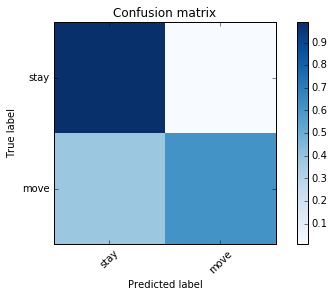

,class 'stay' pred,class 'move' pred
class 'stay' actual,8559,78
class 'move' actual,433,701


In [18]:
X = data[['Home Loan-to-Value - Estimated - Ranges', 'Home Market Value - Estimated', 
          'Income - Estimated Household', 'Generations in Household', 'New Parent', 
          'Marital Status in the Household', 'Expectant Parent', 'Newlywed', 
          'Home Length of Residence', 'Home Square Footage - Actual', 'Home Year Built - Actual']]
y = data['New_Purchase'].as_matrix()

# Split data into training and testing set, with test size 20% of the full data set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the training data and then predict on the test data
fullmodel_rf.fit(X_train,y_train)
y_pred = fullmodel_rf.predict(X_test)


# This function plots the confusion matrix
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['stay','move'], rotation=45)
    plt.yticks(tick_marks, ['stay','move'])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Define a function to output all relevant information, such as accuracy score, 
# classification report which includes precision, recall, f1-score for each class, 
# and the confusion matrix.
def classifier_metrics(y_test, y_pred):
    print "Test Accuracy Score: ", accuracy_score(y_test, y_pred)
    print classification_report(y_test, y_pred)
    # Put the confusion matrix into pandas dataframe for better display
    cm = pd.DataFrame(confusion_matrix(y_test, y_pred), 
                      index = ["class 'stay' actual", "class 'move' actual"],
                      columns = ["class 'stay' pred", "class 'move' pred"])
    # Normalized the confusion matrix by row
    cm_normalized = cm.div(cm.sum(axis=1), axis=0)
    plot_confusion_matrix(cm_normalized)
    plt.show()
    
    return cm
    
classifier_metrics(y_test, y_pred)

### 3.4. Predict the probablity to move

In [9]:
# Predict the probability to move
fullmodel_rf.predict_proba(X_test)

array([[ 0.987,  0.013],
       [ 0.958,  0.042],
       [ 0.999,  0.001],
       ..., 
       [ 0.993,  0.007],
       [ 0.952,  0.048],
       [ 0.996,  0.004]])

## <font color=blue>>> Conlusion:</font>

### <font color=blue>The second column in the above output are the model's predicted probabilities to move. This result is dependent on our model parameters.</font>

### <font color=blue>As shown above, our model's test accuracy score is 94.8%, which is above the 88.7% baseline. From the confusion matrix, and the classification report, one can see that our prediction for 'move' has 90% accuracy, which means 90% of what we predict as 'move' will move. On the other hand, the recall for 'move' is only 62%, which means we only captured 62% of households that are actually moving. From the business perspective, we want to capture more households that are about to move. So one may want to adjust the model parameters, to see whether we can capture more households that are moving. In other words, one can play with the parameters to see whether we can increase the recall by decreasing the precision in our prediction.</font>

# 4. Appendix: Naive Bays Model

One can of couse test some other classifiers, for example the Navie Bays classifiers, to see how they perform. From my test, the random forest classifier seems to be more flexible and gives better results overall in terms of total accuracy, precision, recall and f-1 scores.

Test Accuracy Score:  0.731552553475
             precision    recall  f1-score   support

          0       0.93      0.75      0.83      8637
          1       0.23      0.57      0.33      1134

avg / total       0.85      0.73      0.77      9771



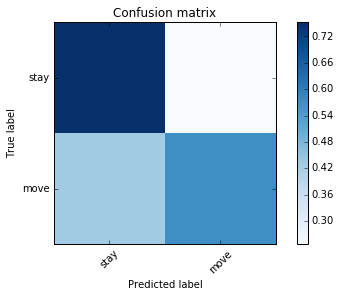

,class 'stay' pred,class 'move' pred
class 'stay' actual,6503,2134
class 'move' actual,489,645


In [19]:
# Use the Gaussian Naive Bayes classifier to construct the full model
fullmodel_nb = Pipeline([('featureunion', features), 
                         ('est', GaussianNB())
                        ])

# Fit the training data and then predict on the test data
fullmodel_nb.fit(X_train,y_train)
y_pred = fullmodel_nb.predict(X_test)

classifier_metrics(y_test, y_pred)

In [20]:
# Predict the probability to move
fullmodel_nb.predict_proba(X_test)

array([[ 0.93941998,  0.06058002],
       [ 0.91050537,  0.08949463],
       [ 0.99100212,  0.00899788],
       ..., 
       [ 0.93084356,  0.06915644],
       [ 0.98583116,  0.01416884],
       [ 0.83106656,  0.16893344]])